#Find the nuclei in divergent images to advance medical discovery

In this dataset we will classify microscopic images of Nucleus  from the 2018 data  Data Science Bowl [Find the nuclei in divergent images to advance medical discovery ](http://www.kaggle.com/c/data-science-bowl-2018) dataset.This dataset contains a large number of segmented nuclei images.  You'll preprocess the images, then train a U-net convolutional neural network on all the samples. The images need to be normalize and we use Data augmentation because we have small dataset. we are apply convolutional, max pooling,concatenate and upsampling At the end, you'll get to see your neural network's predictions on the sample images.
# Get the data
You can download the data hear- [Find the nuclei in divergent images to advance medical discovery ](https://www.kaggle.com/c/data-science-bowl-2018/data)



In [1]:
!pip install tqdm
!curl -LO https://raw.github.com/drj11/pypng/master/code/png.py

import numpy as np 
import skimage.io as io

# from PIL import Image
import pandas as pd
import sys
from urllib.request import urlretrieve
from os.path import isfile, isdir
import zipfile
import os
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize 
from keras.layers import Input
from keras.layers import Lambda
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.models import load_model
import keras.backend as K
np.random.seed(14)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   97k  100   97k    0     0    97k      0  0:00:01 --:--:--  0:00:01   97k


Using TensorFlow backend.


In [2]:
cwd = os.getcwd()

testpath = os.path.join(cwd, 'data', 'test')
trainpath = os.path.join(cwd, 'data', 'train')

if not os.path.exists(trainpath):
    os.makedirs(trainpath)

if not os.path.exists(testpath):
    os.makedirs(testpath)

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

test_url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/8089/stage1_test.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1528705125&Signature=s4l3z%2BRBxrCY%2BbUCNUy2gh17CUzpISBYbzDELFuXTri0WEsbE5RP83Ur80LiTd5N%2FP8%2FEI2q67hlqPOHstxduoUxgduGxbtB4via5jXKCrfeHcjV8hp6wOvkGe1pG7BQYO3sh58jjQbYvh4HbQojFrV4dRWK%2B%2Bs4KrgTgzWMsQ9zwKmt5Q%2BQ5cSNvspW8SlSJV8qm29g34YNb9zUmNeIA%2BVHOMuk3RHfXtCc%2Fy3DE%2Fydqok4fuwNSmf9h8HQfoRYmiqb%2Fl5MosO3hLTsIsW3f2tz4sRUdZlRj2%2Fi85hoWIfGu1o4IHkqDOb%2BOp%2FmXcBqQWZFTVjw9FOjJguzVhFxMw%3D%3D'
train_url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/8089/stage1_train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1528705180&Signature=pEWiqKeYz0IQDphaFtmPkz2lQJ9HxcCP1XBftQuMQbT3RO66khScR1lUuxu7dYVR9sW1qwPeSYChOWSVXkKl%2BSpamYAh7uf%2B5cfTHAUmH%2Fvkt3Q2oJ77c9ILoEm2mlMC1ik%2BqIXTQFwJAB0r0y5vRSo61e0QoFRvtSNaw5OgnyNtGnHqO4yWwk7RAFv8pFBa9A0zNyhJWScLG%2F1%2FUkiBgv2M1tsWYkRY0GYju5fWTitkbUIhh%2BvnrwyNNPg3EQzb9GM7GOrY1k%2FYlEfLhwFjFAPvUI98nvVFZfruBLN4nzWr%2B%2FI9rB33%2FQudeqkjcqR%2FWEJ3pM%2FekwabLKb%2FFg5FcA%3D%3D'

if not isfile('stage1_train.zip'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Download Train Data') as pbar:
        urlretrieve(
            train_url,
            'stage1_train.zip',
            pbar.hook)
        
        
if not isfile('stage1_test.zip'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Download Test Data') as pbar:
        urlretrieve(
            test_url,  
            'stage1_test.zip',
            pbar.hook)

with zipfile.ZipFile('stage1_train.zip') as zip_file:
    cwd = os.getcwd()
    zip_file.extractall(os.path.join(cwd, 'data', 'train'))
    zip_file.close()

with zipfile.ZipFile('stage1_test.zip') as zip_file:
    cwd = os.getcwd()
    zip_file.extractall(os.path.join(cwd, 'data', 'test'))
    zip_file.close()

print('All files Found')

All files Found


In [0]:
IMAGES_WIDTH = 256
IMAGES_HEIGHT = 256
IMAGES_DEPTH = 3

TRAIN_PATH = os.path.join('data', 'train')
TEST_PATH = os.path.join('data', 'test')

def get_ids(path):
    return os.listdir(path)

In [4]:
def get_full_paths_train(path):
    features_path = []
    labels_path = []
    
    for id in get_ids(TRAIN_PATH):
        cons_path = os.path.join(TRAIN_PATH, id, 'masks')
        feature_path  = os.path.join(TRAIN_PATH, id, 'images', id + '.png')
        label_paths  = [os.path.join(cons_path, path) for path in get_ids(os.path.join(TRAIN_PATH, id, 'masks'))]
        features_path.append(feature_path)
        labels_path.append(label_paths)
    return features_path, labels_path

def get_full_paths_test(path):
    feature = []
    for id in get_ids(TEST_PATH):
        feature_path  = os.path.join(TEST_PATH, id, 'images', id + '.png')
        feature.append(feature_path)
    return feature

features_list = np.zeros((len(get_ids(TRAIN_PATH)), IMAGES_WIDTH, IMAGES_HEIGHT, IMAGES_DEPTH), dtype = np.uint8)
labels_list = np.zeros((len(get_ids(TRAIN_PATH)), IMAGES_WIDTH, IMAGES_HEIGHT, 1), dtype = np.uint8)

sys.stdout.flush()


def get_feature_images(paths, features_list):
    for i, path in enumerate(paths):
        image = imread(path)[:, :, :IMAGES_DEPTH]
        image = resize(image, (IMAGES_WIDTH, IMAGES_HEIGHT), mode='constant', preserve_range=True)
        features_list[i] = image
    return features_list
    
def get_train_mask_images(paths, labels_list):
    for i, path in enumerate(paths):
        collection_images = io.ImageCollection(path)
        mask = np.zeros((IMAGES_WIDTH, IMAGES_HEIGHT, 1), dtype = np.uint8)
        for imges in collection_images:
            img = resize(imges,  (IMAGES_WIDTH, IMAGES_HEIGHT, 1), preserve_range=False)
            mask = np.maximum(mask, img)
        labels_list[i] = mask
    return labels_list

sys.stdout.flush()

test_feature =  np.zeros((len(get_ids(TEST_PATH)), IMAGES_WIDTH, IMAGES_HEIGHT, IMAGES_DEPTH), dtype = np.uint8)

def get_test_features_images(paths, test_feature_list):
    for i, path in enumerate(paths):
        image = imread(path)[:, :, :IMAGES_DEPTH]
        resized_image = resize(image, (IMAGES_WIDTH, IMAGES_HEIGHT), preserve_range=False)
        test_feature_list[i] = resized_image
    return test_feature_list
    


features_paths, labels_paths = get_full_paths_train(TRAIN_PATH)
test_features_paths = get_full_paths_test(TEST_PATH)

print('Getting Training Data...')

X_train = get_feature_images(features_paths, features_list)
Y_train = get_train_mask_images(labels_paths, labels_list)

print('Training data loading completed!')

print('Getting Testing Data...')

X_test = get_feature_images(test_features_paths, test_feature)

print('Testing data loading completed!')


print('we have {} Training Images and {} Testing Images Found.'.format(len(X_train), len(X_test)))

print('All data completely loaded!')

Getting Training Data...


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Training data loading completed!
Getting Testing Data...
Testing data loading completed!
we have 670 Training Images and 65 Testing Images Found.
All data completely loaded!


# Visulization Images And Masks
We have 670 Training examples, now i am generating random index and visulize images and mask, i make `display_images` method, this method has three inputs, `X_train`, `Y_train` and `id_`. the `id_` input conain indexes. i am randomly generate id_ and visulize images and mask, run below comand.

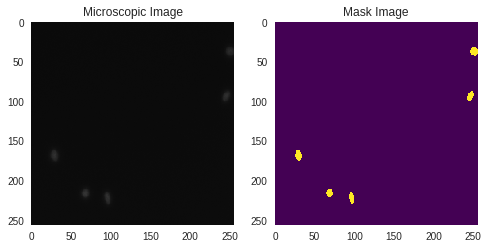

In [5]:
def display_images(id_, X_train, Y_train):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    ax1.set_title('Microscopic Image')
    ax1.grid(False)
    ax1.imshow(X_train[id_])

    ax2.set_title('Mask Image')
    ax2.grid(False)
    ax2.imshow(np.squeeze(Y_train[id_]), cmap="viridis")
    plt.show()

id_ = np.random.randint(len(X_train))
display_images(id_, X_train, Y_train)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `X_train and X_test`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `X_train and X_test`.

In [0]:
def normalize(x):
    samples = []
    for sample in x:
        samples.append(sample / 255)
    return np.array(samples)

X_train = normalize(X_train)
X_test = normalize(X_test)

# Metrics

This project is evaluated on the mean average precision at different intersection over union (IoU) thresholds. The IoU of a proposed set of object pixels and a set of true object pixels is calculated as:

\begin{align}
IoU(A,B) = \frac{A \cap B}{ A \cup B}.
\end{align}

The metric sweeps over a range of IoU thresholds, at each point calculating an average precision value. The threshold values range from 0.5 to 0.95 with a step size of 0.05: (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95). In other words, at a threshold of 0.5, a predicted object is considered a "hit" if its intersection over union with a ground truth object is greater than 0.5.
At each threshold value tt, a precision value is calculated based on the number of true positives (TP), false negatives (FN), and false positives (FP) resulting from comparing the predicted object to all ground truth objects:

\begin{align}
\frac{TP(t)}{TP(t) + FP(t) + FN(t)}.
\end{align}

A true positive is counted when a single predicted object matches a ground truth object with an IoU above the threshold. A false positive indicates a predicted object had no associated ground truth object. A false negative indicates a ground truth object had no associated predicted object. The average precision of a single image is then calculated as the mean of the above precision values at each IoU threshold:

\begin{align}
\frac{1}{|thresholds|} \sum_t \frac{TP(t)}{TP(t) + FP(t) + FN(t)}.
\end{align}

Lastly, the score returned by the project metric is the mean taken over the individual average precisions of each image in the test dataset.

Reference: 

[https://www.kaggle.com/c/data-science-bowl-2018#evaluation](https://www.kaggle.com/c/data-science-bowl-2018#evaluation)

In [0]:
def IoU(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In this method has two parameter y_true and y_pred, first we make prec array, we are set the loop with (0.5, 1.0, 0.05). when loop run we found single value for each loop,  we have some thresholds like this. (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95). when loop run we found single threshold value. for example when loop run first time run we found o.5  value,  we compare this threshold to our y_pred .(if predicted y_pred is greater than  0.5 we return 1 else 0).  Then we calculate mean IoU score. we add those score value in our list, for each loop same process happen compare thresholds values calculate mean IoU score and add IoU score in our list. we have 10 threshold so our loop run ten time and all those process happen 10 time, so in our list have 10 scores available finally we calculate mean in our score list with axis 0. Then we found our intersection over union score.

[Reference of this code](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277)

# Build the network
In this project we build U-net Convolutional Networks for Image Segmentation.The u-net is convolutional network architecture for fast and precise segmentation of images. Up to now it has outperformed the prior best method (a sliding-window convolutional network) on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks. It has won the Grand Challenge for Computer-Automated Detection of Caries in Bitewing Radiography at ISBI 2015, and it has won the Cell Tracking Challenge at ISBI 2015 on the two most challenging transmitted light microscopy categories (Phase contrast and DIC microscopy) by a large margin . and we use this CNN archistructure. [Papers](https://arxiv.org/pdf/1505.04597.pdf)
![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

[Reference Link](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)

[Reference Of This Information Link](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)

In [8]:
def create_model():
    
    inputs = Input((IMAGES_WIDTH, IMAGES_HEIGHT, IMAGES_DEPTH))
    
    conv = Conv2D(16, (3, 3), padding='same', activation='relu')(inputs)
    conv = Conv2D(16, (3, 3), padding='same', activation='relu')(conv)
    p = MaxPooling2D((2, 2))(conv)
    
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(p)
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv1)
    p1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(p1)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv2)
    p2 = MaxPooling2D((2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(p2)
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv3)
    p3 = MaxPooling2D((2, 2))(conv3)
    
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu')(p3)
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv4)
    
    m = concatenate([
        Conv2D(128, (2, 2), padding='same', activation='relu')(UpSampling2D(size = (2, 2)) (conv4)),
        conv3
    ])
    
    conv5 = Conv2D(128, (3, 3), padding='same', activation='relu')(m)
    conv5 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv5)
    
    m1 = concatenate([
        Conv2D(64, (2, 2), padding='same', activation='relu')(UpSampling2D(size = (2, 2)) (conv5)),
        conv2
    ])
    
    conv6 = Conv2D(64, (3, 3), padding='same', activation='relu')(m1)
    conv6 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv6)
    
    m2 = concatenate([
        Conv2D(32, (2, 2), padding='same', activation='relu')(UpSampling2D(size = (2, 2)) (conv6)),
        conv1
    ])
    
    conv7 = Conv2D(32, (3, 3), padding='same', activation='relu')(m2)
    conv7 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv7)
    
    m3 = concatenate([
        Conv2D(16, (2, 2), padding='same', activation='relu')(UpSampling2D(size = (2, 2)) (conv7)),
        conv
    ])
    
    conv8 = Conv2D(16, (3, 3), padding='same', activation='relu')(m3)
    conv8 = Conv2D(16, (3, 3), padding='same', activation='relu')(conv8)
    
    output = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(conv8)
    
    model = Model(inputs = inputs, outputs = output)
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = [IoU])
    return model
    
model = create_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

# Train the model
Now we train our model, before we train the model we set our callbacks
*   **ModelCheckpoint** :  For example: if filepath  is **model-capstone_project_udacity_by_jimit_jaishwal**, then the model checkpoints will be saved with the epoch number and the validation loss in the filename.
*  **EarlyStopping** : Stop training when a monitored quantity has stopped improving.

In [9]:
stoper = EarlyStopping(verbose=1, patience=7)
FILE_PATH = 'model-capstone_project_udacity_by_jimit_jaishwal.h5'
checkpointer = ModelCheckpoint(FILE_PATH, verbose=1, save_best_only=True)


BATCH = 8
EPOCH = 40

model.fit(epochs= EPOCH, x = X_train,
          y = Y_train, 
          batch_size = BATCH,
          validation_split = 0.1,
          callbacks=[stoper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/40
603/603 [==============================] - 27s 45ms/step - loss: 0.4554 - IoU: 0.4253 - val_loss: 0.2395 - val_IoU: 0.4335

Epoch 00001: val_loss improved from inf to 0.23948, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 2/40
603/603 [==============================] - 22s 36ms/step - loss: 0.2166 - IoU: 0.4422 - val_loss: 0.1827 - val_IoU: 0.4584

Epoch 00002: val_loss improved from 0.23948 to 0.18270, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 3/40
603/603 [==============================] - 22s 36ms/step - loss: 0.1379 - IoU: 0.4839 - val_loss: 0.1240 - val_IoU: 0.5244

Epoch 00003: val_loss improved from 0.18270 to 0.12396, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 4/40
 72/603 [==>...........................] - ETA: 18s - loss: 0.1064 - IoU: 0.5328

603/603 [==============================] - 22s 36ms/step - loss: 0.1136 - IoU: 0.5589 - val_loss: 0.1086 - val_IoU: 0.5832

Epoch 00004: val_loss improved from 0.12396 to 0.10858, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 5/40
603/603 [==============================] - 22s 36ms/step - loss: 0.1054 - IoU: 0.6034 - val_loss: 0.1073 - val_IoU: 0.6217

Epoch 00005: val_loss improved from 0.10858 to 0.10731, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 6/40
603/603 [==============================] - 22s 36ms/step - loss: 0.0926 - IoU: 0.6380 - val_loss: 0.1132 - val_IoU: 0.6523

Epoch 00006: val_loss did not improve from 0.10731
Epoch 7/40
216/603 [=========>....................] - ETA: 13s - loss: 0.0949 - IoU: 0.6571

603/603 [==============================] - 22s 36ms/step - loss: 0.0930 - IoU: 0.6635 - val_loss: 0.1125 - val_IoU: 0.6731

Epoch 00007: val_loss did not improve from 0.10731
Epoch 8/40
603/603 [==============================] - 22s 36ms/step - loss: 0.0888 - IoU: 0.6821 - val_loss: 0.1097 - val_IoU: 0.6908

Epoch 00008: val_loss did not improve from 0.10731
Epoch 9/40
603/603 [==============================] - 22s 37ms/step - loss: 0.0830 - IoU: 0.6983 - val_loss: 0.1080 - val_IoU: 0.7061

Epoch 00009: val_loss did not improve from 0.10731
Epoch 10/40
504/603 [========================>.....] - ETA: 3s - loss: 0.0754 - IoU: 0.7121

603/603 [==============================] - 22s 36ms/step - loss: 0.0764 - IoU: 0.7131 - val_loss: 0.0999 - val_IoU: 0.7195

Epoch 00010: val_loss improved from 0.10731 to 0.09989, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 11/40
603/603 [==============================] - 22s 36ms/step - loss: 0.0792 - IoU: 0.7246 - val_loss: 0.1017 - val_IoU: 0.7301

Epoch 00011: val_loss did not improve from 0.09989
Epoch 12/40
603/603 [==============================] - 22s 36ms/step - loss: 0.0745 - IoU: 0.7342 - val_loss: 0.0921 - val_IoU: 0.7392

Epoch 00012: val_loss improved from 0.09989 to 0.09206, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 13/40
320/603 [==============>...............] - ETA: 9s - loss: 0.0714 - IoU: 0.7417 

603/603 [==============================] - 22s 36ms/step - loss: 0.0720 - IoU: 0.7435 - val_loss: 0.1018 - val_IoU: 0.7476

Epoch 00013: val_loss did not improve from 0.09206
Epoch 14/40
603/603 [==============================] - 22s 36ms/step - loss: 0.0719 - IoU: 0.7512 - val_loss: 0.0997 - val_IoU: 0.7549

Epoch 00014: val_loss did not improve from 0.09206
Epoch 15/40
603/603 [==============================] - 22s 36ms/step - loss: 0.0726 - IoU: 0.7581 - val_loss: 0.1062 - val_IoU: 0.7611

Epoch 00015: val_loss did not improve from 0.09206
Epoch 16/40
512/603 [========================>.....] - ETA: 3s - loss: 0.0718 - IoU: 0.7633

603/603 [==============================] - 22s 36ms/step - loss: 0.0732 - IoU: 0.7637 - val_loss: 0.0905 - val_IoU: 0.7665

Epoch 00016: val_loss improved from 0.09206 to 0.09053, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 17/40
603/603 [==============================] - 22s 36ms/step - loss: 0.0698 - IoU: 0.7689 - val_loss: 0.0912 - val_IoU: 0.7713

Epoch 00017: val_loss did not improve from 0.09053
Epoch 18/40
603/603 [==============================] - 22s 36ms/step - loss: 0.0704 - IoU: 0.7736 - val_loss: 0.0910 - val_IoU: 0.7759

Epoch 00018: val_loss did not improve from 0.09053
Epoch 19/40
352/603 [================>.............] - ETA: 8s - loss: 0.0705 - IoU: 0.7771

603/603 [==============================] - 22s 36ms/step - loss: 0.0683 - IoU: 0.7779 - val_loss: 0.0887 - val_IoU: 0.7800

Epoch 00019: val_loss improved from 0.09053 to 0.08869, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 20/40
603/603 [==============================] - 22s 36ms/step - loss: 0.0681 - IoU: 0.7819 - val_loss: 0.0928 - val_IoU: 0.7837

Epoch 00020: val_loss did not improve from 0.08869
Epoch 21/40
603/603 [==============================] - 22s 36ms/step - loss: 0.0687 - IoU: 0.7853 - val_loss: 0.0880 - val_IoU: 0.7869

Epoch 00021: val_loss improved from 0.08869 to 0.08796, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 22/40
304/603 [==============>...............] - ETA: 10s - loss: 0.0670 - IoU: 0.7878

603/603 [==============================] - 22s 36ms/step - loss: 0.0654 - IoU: 0.7885 - val_loss: 0.0930 - val_IoU: 0.7901

Epoch 00022: val_loss did not improve from 0.08796
Epoch 23/40
603/603 [==============================] - 22s 36ms/step - loss: 0.0649 - IoU: 0.7916 - val_loss: 0.0845 - val_IoU: 0.7931

Epoch 00023: val_loss improved from 0.08796 to 0.08450, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 24/40
603/603 [==============================] - 22s 36ms/step - loss: 0.0641 - IoU: 0.7945 - val_loss: 0.0876 - val_IoU: 0.7959

Epoch 00024: val_loss did not improve from 0.08450
Epoch 25/40
392/603 [==================>...........] - ETA: 7s - loss: 0.0634 - IoU: 0.7967

603/603 [==============================] - 22s 36ms/step - loss: 0.0634 - IoU: 0.7971 - val_loss: 0.0880 - val_IoU: 0.7984

Epoch 00025: val_loss did not improve from 0.08450
Epoch 26/40
603/603 [==============================] - 22s 36ms/step - loss: 0.0638 - IoU: 0.7996 - val_loss: 0.0793 - val_IoU: 0.8009

Epoch 00026: val_loss improved from 0.08450 to 0.07928, saving model to model-capstone_project_udacity_by_jimit_jaishwal.h5
Epoch 27/40
603/603 [==============================] - 22s 36ms/step - loss: 0.0636 - IoU: 0.8019 - val_loss: 0.0853 - val_IoU: 0.8030

Epoch 00027: val_loss did not improve from 0.07928
Epoch 28/40
400/603 [==================>...........] - ETA: 6s - loss: 0.0661 - IoU: 0.8037

603/603 [==============================] - 22s 36ms/step - loss: 0.0635 - IoU: 0.8040 - val_loss: 0.0832 - val_IoU: 0.8051

Epoch 00028: val_loss did not improve from 0.07928
Epoch 29/40
603/603 [==============================] - 22s 37ms/step - loss: 0.0618 - IoU: 0.8061 - val_loss: 0.0824 - val_IoU: 0.8071

Epoch 00029: val_loss did not improve from 0.07928
Epoch 30/40
603/603 [==============================] - 22s 36ms/step - loss: 0.0601 - IoU: 0.8080 - val_loss: 0.0819 - val_IoU: 0.8091

Epoch 00030: val_loss did not improve from 0.07928
Epoch 31/40
520/603 [========================>.....] - ETA: 2s - loss: 0.0679 - IoU: 0.8097

603/603 [==============================] - 22s 36ms/step - loss: 0.0688 - IoU: 0.8098 - val_loss: 0.0868 - val_IoU: 0.8105

Epoch 00031: val_loss did not improve from 0.07928
Epoch 32/40
603/603 [==============================] - 22s 37ms/step - loss: 0.0640 - IoU: 0.8113 - val_loss: 0.0870 - val_IoU: 0.8121

Epoch 00032: val_loss did not improve from 0.07928
Epoch 33/40
603/603 [==============================] - 22s 36ms/step - loss: 0.0620 - IoU: 0.8128 - val_loss: 0.0798 - val_IoU: 0.8136

Epoch 00033: val_loss did not improve from 0.07928
Epoch 00033: early stopping


#  Prediction
Now we are predicting a validation train and test dataset and  check how accurate our CNN model?

In [0]:
model = load_model(filepath=FILE_PATH, custom_objects={'IoU' : IoU})

def set_threshold(preds):
    return (preds > 0.5).astype(np.uint8)

predict_train_set = model.predict(X_train)
predict_test_set = model.predict(X_test)

predict_train_set = set_threshold(predict_train_set)
predict_test_set = set_threshold(predict_test_set)

# Visualize Train Prediction

Now we test and visualize our predicting train results and check how well model perform. 

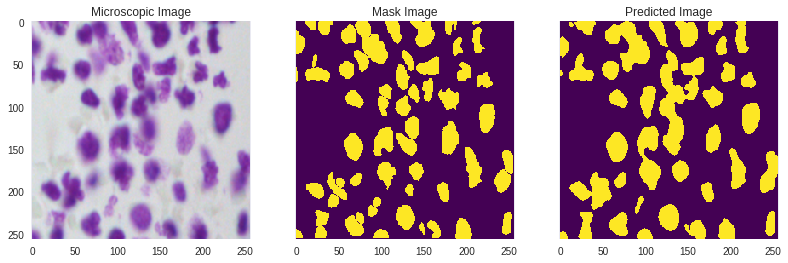

In [11]:
def display_results(id_, X_train, Y_train, predicted):
    fig, arr = plt.subplots(1, 3, figsize=(13.4, 4), sharey=True,sharex=True)
    arr[0].set_title('Microscopic Image')
    arr[0].grid(False)
    arr[0].imshow(X_train[id_])

    arr[1].set_title('Mask Image')
    arr[1].grid(False)
    arr[1].imshow(np.squeeze(Y_train[id_]), cmap="viridis")
    
    arr[2].imshow(np.squeeze(predicted[id_]), cmap="viridis")
    arr[2].set_title('Predicted Image')
    arr[2].grid(False)
        
id_ = np.random.randint(0, len(predict_train_set))
display_results(id_, X_train, Y_train, predict_train_set)

# Visualize Test Prediction

To test how well our model working i create 4 random images from test images and check how prediction is?

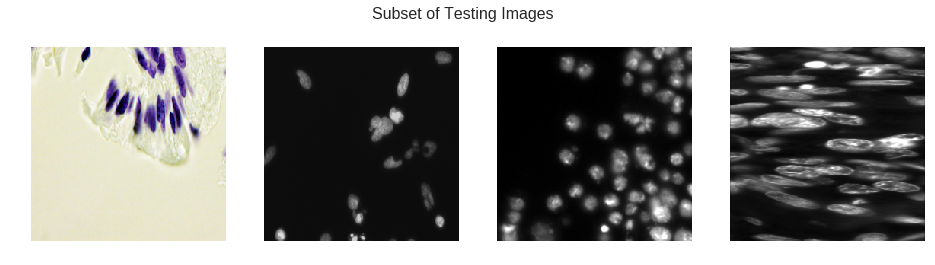

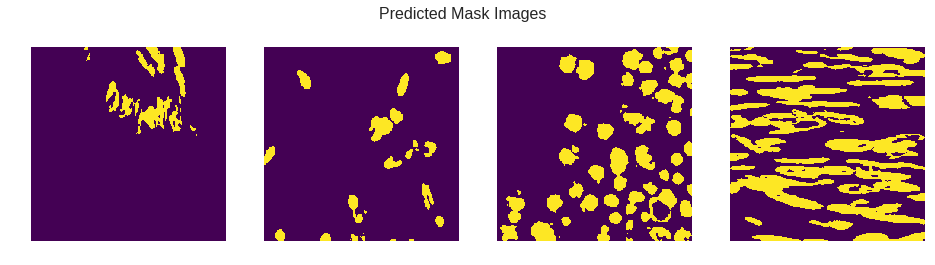

In [12]:
number_list = np.random.randint(len(X_test), size=4)

# visualize subset of training data
fig = plt.figure(figsize=(16,4))
j = 0
for i in number_list:
    ax = fig.add_subplot(1, 4, j+1)
    ax.grid(False)
    ax.imshow(X_test[i])
    ax.axis('off')
    j += 1
fig.suptitle('Subset of Testing Images',  fontsize=16)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(16,4))
k = 0
for i in number_list:
    ax = fig.add_subplot(1, 4, k+1)
    ax.grid(False)
    ax.axis('off')
    ax.imshow(np.squeeze(predict_test_set[i]),  cmap="viridis")
    k += 1
fig.suptitle('Predicted Mask Images', fontsize=16)
plt.show()

# Save Results in local disks
now we save all predicted test images in local disks.

In [13]:
import png 
resultspath = os.path.join(cwd, 'results')

if not os.path.exists(resultspath):
    os.makedirs(resultspath)

test_ids = get_ids(TEST_PATH)

for index, image in enumerate(predict_test_set):
    image_id = test_ids[index] + '.png'
    png.from_array(image, 'L').save(os.path.join(resultspath, image_id))  

print('All images saved successfully!')

All images saved successfully!
